In [29]:
import pandas as pd
import re
import string
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder here

# Load data
df = pd.read_excel("EmotionTweets.xlsx")

# Inspect columns
print(df.columns)

# Split the single column into two columns
df[['text', 'emotion']] = df[df.columns[0]].str.split(';', expand=True)

# Preprocessing function
def clean_text(text):
    text = re.sub(r"http\S+", "", text)  # remove links
    text = re.sub(r"@\w+", "", text)     # remove mentions
    text = re.sub(r"#\w+", "", text)     # remove hashtags
    text = re.sub(r"\d+", "", text)      # remove numbers
    text = re.sub(rf"[{string.punctuation}]", "", text)  # remove punctuation
    text = text.lower().strip()
    return text

df['clean_text'] = df['text'].astype(str).apply(clean_text)

# Encode labels - moved this from a later cell
le = LabelEncoder()
df['label'] = le.fit_transform(df['emotion'])


# Display the first few rows to check the result
display(df.head())

Index(['im feeling rather rotten so im not very ambitious right now;sadness'], dtype='object')


,im feeling rather rotten so im not very ambitious right now;sadness,text,emotion,clean_text,label
0,im updating my blog because i feel shitty;sadness,im updating my blog because i feel shitty,sadness,im updating my blog because i feel shitty,4
1,i never make her separate from me because i do...,i never make her separate from me because i do...,sadness,i never make her separate from me because i do...,4
2,i left with my bouquet of red and yellow tulip...,i left with my bouquet of red and yellow tulip...,joy,i left with my bouquet of red and yellow tulip...,2
3,i was feeling a little vain when i did this on...,i was feeling a little vain when i did this one,sadness,i was feeling a little vain when i did this one,4
4,i cant walk into a shop anywhere where i do no...,i cant walk into a shop anywhere where i do no...,fear,i cant walk into a shop anywhere where i do no...,1


In [3]:
pip install transformers datasets scikit-learn


In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BertTokenizerFast, BertForSequenceClassification, TrainingArguments, Trainer
import torch

# The label encoding code was moved to the data cleaning cell.
# Encode labels
# le = LabelEncoder()
# df['label'] = le.fit_transform(df['emotion'])

In [7]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['clean_text'], df['label'], test_size=0.2, random_state=42)

In [15]:
# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Tokenize
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True)

In [16]:
# Convert to Dataset
train_dataset = Dataset.from_dict({**train_encodings, "labels": train_labels.tolist()})
val_dataset = Dataset.from_dict({**val_encodings, "labels": val_labels.tolist()})

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(le.classes_))


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir="./logs",
    logging_steps=10,
    eval_strategy="no"
)


In [19]:
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="macro")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: thasnirsathar1 (thasnirsathar1-manappuram-insurance) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,1.747400
20,1.612100
30,1.575700
40,1.416000
50,1.413600
60,1.164400
70,1.128300
80,1.141700
90,0.906100
100,0.869700


TrainOutput(global_step=300, training_loss=0.7357818110783895, metrics={'train_runtime': 4065.237, 'train_samples_per_second': 1.18, 'train_steps_per_second': 0.074, 'total_flos': 162704058732072.0, 'train_loss': 0.7357818110783895, 'epoch': 3.0})

              precision    recall  f1-score   support

       anger       0.88      0.88      0.88        49
        fear       0.78      0.87      0.82        45
         joy       0.92      0.90      0.91       137
        love       0.53      0.55      0.54        31
     sadness       0.90      0.95      0.93       124
    surprise       1.00      0.29      0.44        14

    accuracy                           0.86       400
   macro avg       0.83      0.74      0.75       400
weighted avg       0.87      0.86      0.86       400



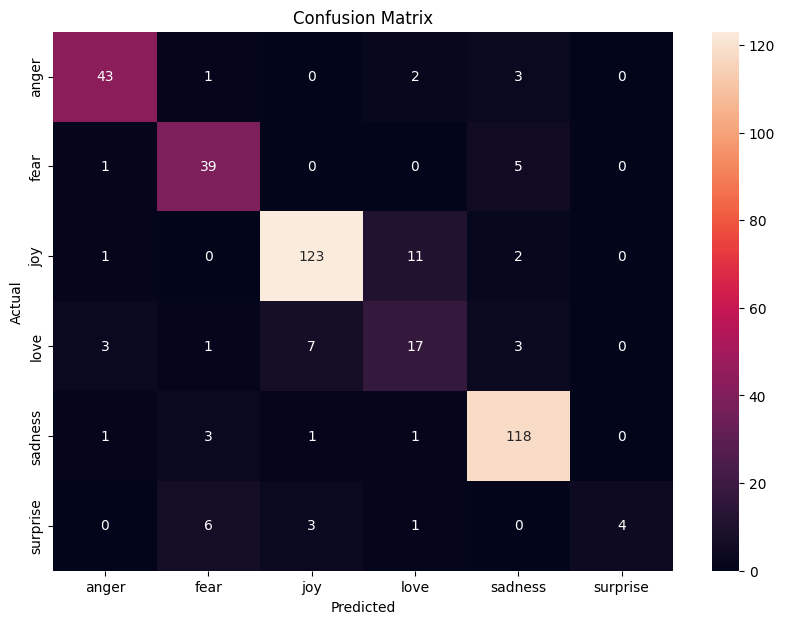

In [21]:
preds_output = trainer.predict(val_dataset)
preds = np.argmax(preds_output.predictions, axis=1)

# Print classification report
print(classification_report(val_labels, preds, target_names=le.classes_))

# Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(val_labels, preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [22]:
# Save model and tokenizer
model.save_pretrained("emotion-bert-model")
tokenizer.save_pretrained("emotion-bert-model")

# Save LabelEncoder
import pickle
with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


In [25]:
!streamlit run app.py

/bin/bash: line 1: streamlit: command not found


In [26]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.1 MB/s eta 0:00:00


In [27]:
# Save this as `app.py`
import streamlit as st
from transformers import BertTokenizerFast, BertForSequenceClassification
import torch
import pickle

# Load model, tokenizer, and label encoder
model = BertForSequenceClassification.from_pretrained("emotion-bert-model")
tokenizer = BertTokenizerFast.from_pretrained("emotion-bert-model")
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

st.title("Emotion Detection from Tweets")
text = st.text_area("Enter a tweet:")

if st.button("Predict"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    pred = torch.argmax(probs, axis=1).item()
    emotion = le.inverse_transform([pred])[0]

    st.write(f"**Predicted Emotion:** {emotion}")
    st.bar_chart(probs.detach().numpy()[0])


2025-07-11 07:44:24.665 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:24.934 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-07-11 07:44:24.941 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:24.945 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:24.955 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:24.962 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:24.970 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:44:24.973 Thread 'MainThread': mi

In [31]:
!streamlit run app.py

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(df['clean_text'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = LogisticRegression(max_iter=200)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(classification_report(y_test, preds, target_names=le.classes_))


KeyError: 'label'

In [32]:
# app.py

import streamlit as st
from transformers import BertTokenizerFast, BertForSequenceClassification
import torch
import pickle

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("emotion-bert-model")
tokenizer = BertTokenizerFast.from_pretrained("emotion-bert-model")

# Load LabelEncoder
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

st.title("🧠 Emotion Detection from Tweets")

text = st.text_area("Enter a tweet:")

if st.button("Predict Emotion"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    emotion = le.inverse_transform([pred_class])[0]

    st.subheader(f"Predicted Emotion: **{emotion}**")

    # Show probabilities
    st.subheader("Emotion Probabilities")
    prob_dict = {label: float(probs[0][i]) for i, label in enumerate(le.classes_)}
    st.bar_chart(prob_dict)


2025-07-11 07:49:51.380 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:49:51.385 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:49:51.389 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:49:51.393 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:49:51.396 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:49:51.400 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:49:51.404 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-07-11 07:49:51.408 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [33]:
streamlit run app.py


SyntaxError: invalid syntax (ipython-input-33-507122745.py, line 1)

In [34]:
!streamlit run app.py


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [35]:
# Save app code into app.py
app_code = """
import streamlit as st
from transformers import BertTokenizerFast, BertForSequenceClassification
import torch
import pickle

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("emotion-bert-model")
tokenizer = BertTokenizerFast.from_pretrained("emotion-bert-model")

# Load LabelEncoder
with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

st.title("🧠 Emotion Detection from Tweets")

text = st.text_area("Enter a tweet:")

if st.button("Predict Emotion"):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    pred_class = torch.argmax(probs, dim=1).item()
    emotion = le.inverse_transform([pred_class])[0]

    st.subheader(f"Predicted Emotion: **{emotion}**")

    # Show probabilities
    st.subheader("Emotion Probabilities")
    prob_dict = {label: float(probs[0][i]) for i, label in enumerate(le.classes_)}
    st.bar_chart(prob_dict)
"""

with open("app.py", "w") as f:
    f.write(app_code)


In [36]:
!streamlit run app.py





  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.139.93.236:8501

http://localhost:8501
  Stopping...
^C
